# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных


**Технологический процесс**

• Rougher feed — исходное сырье

• Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
	○ Xanthate **— ксантогенат (промотер, или активатор флотации);
	○ Sulphate — сульфат (на данном производстве сульфид натрия);
	○ Depressant — депрессант (силикат натрия).
    
• Rougher process (англ. «грубый процесс») — флотация

• Rougher tails — отвальные хвосты

• Float banks — флотационная установка

• Cleaner process — очистка

• Rougher Au — черновой концентрат золота

• Final Au — финальный концентрат золота

**Параметры этапов**

• air amount — объём воздуха

• fluid levels — уровень жидкости

• feed size — размер гранул сырья

• feed rate — скорость подачи

**Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра] Пример: rougher.input.feed_ag Возможные значения для блока [этап]:**

• rougher — флотация

• primary_cleaner — первичная очистка

• secondary_cleaner — вторичная очистка

• final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**

• input — параметры сырья

• output — параметры продукта

• state — параметры, характеризующие текущее состояние этапа

• calculation — расчётные характеристики


## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
)

from sklearn.metrics import ( 
    fbeta_score, 
    make_scorer, 
    mean_absolute_error, 
)

### Откроем файлы и изучим их

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
datasets = [data_train, data_test, data_full]
for dataset in datasets:
  display(dataset.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
for dataset in datasets:
  display(dataset.describe(include='all'))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14149,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
unique,14149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-02-15 10:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,NaN,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,NaN,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,NaN,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,NaN,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5290,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
unique,5290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-11-06 18:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,NaN,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,NaN,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,NaN,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,NaN,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,NaN,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19439,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
unique,19439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-02-15 10:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,NaN,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,NaN,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,NaN,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,NaN,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378


In [5]:
for dataset in datasets:
  display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

In [6]:
for dataset in datasets:
  display(dataset.shape)

(14149, 87)

(5290, 53)

(19439, 87)

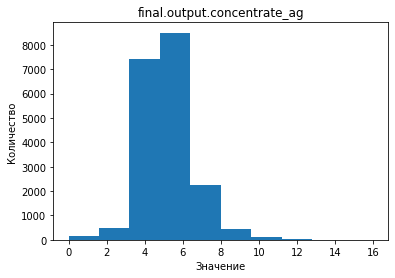

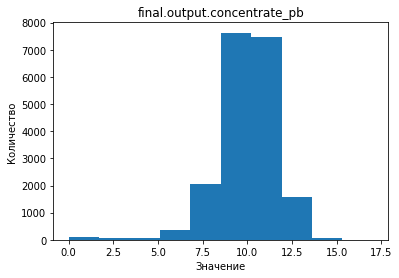

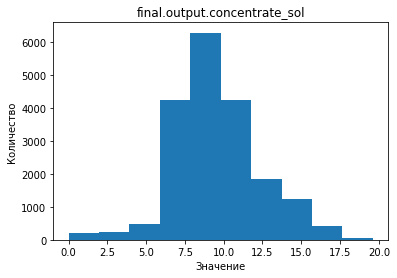

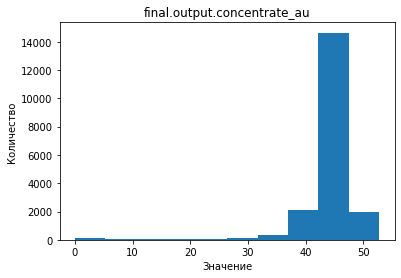

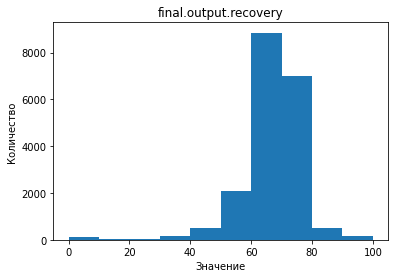

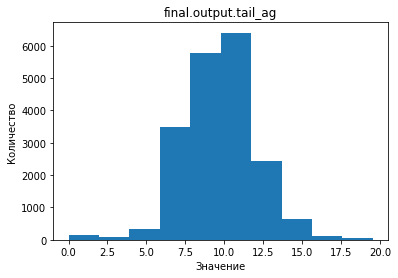

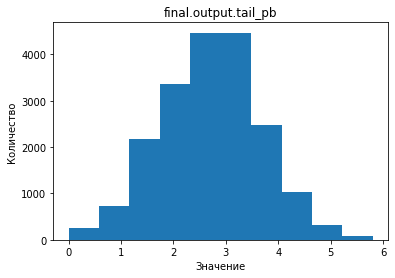

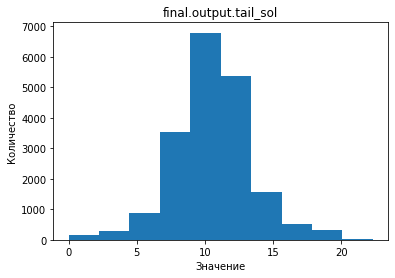

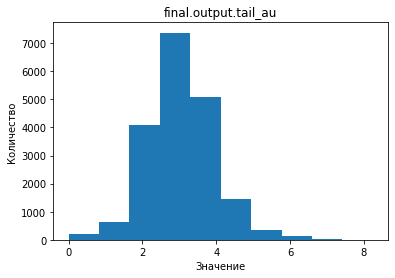

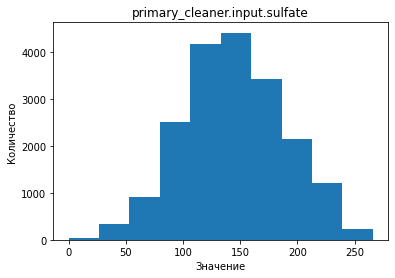

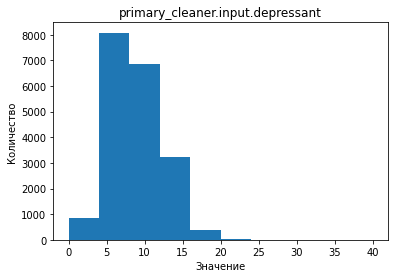

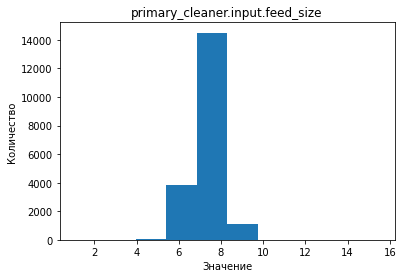

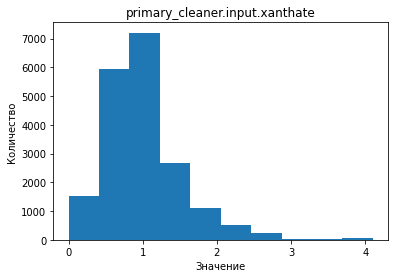

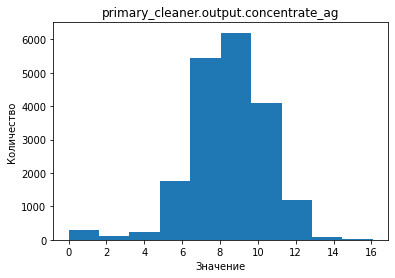

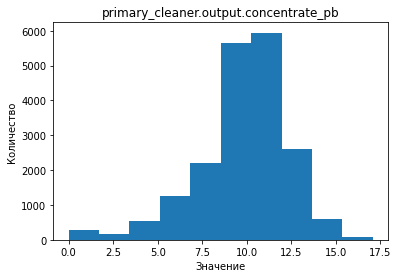

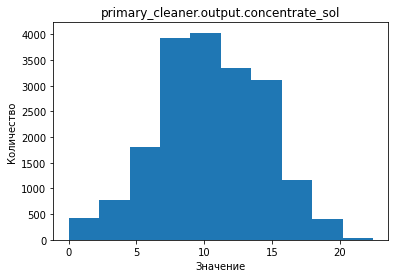

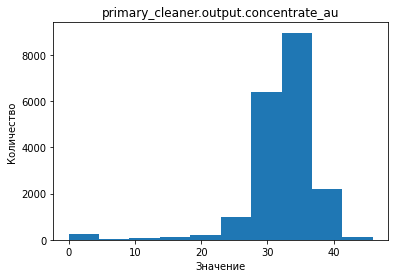

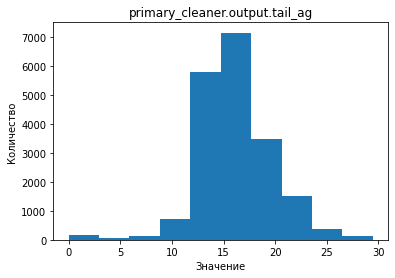

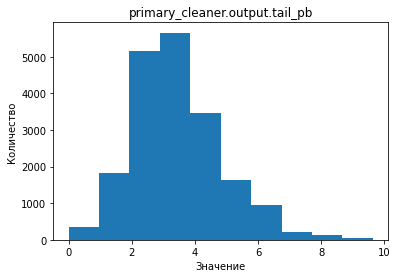

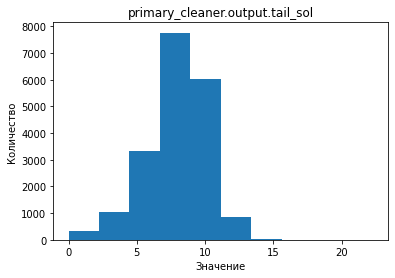

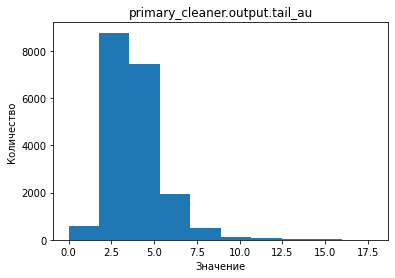

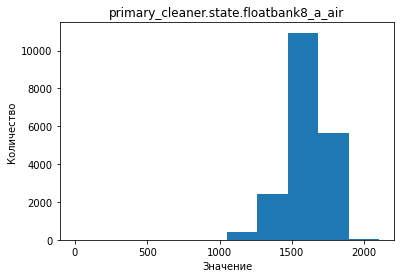

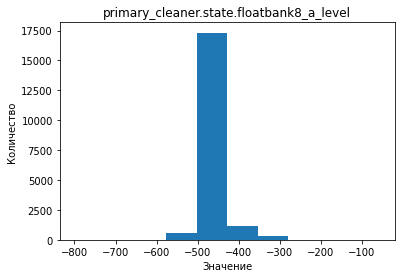

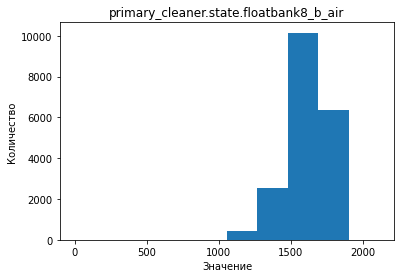

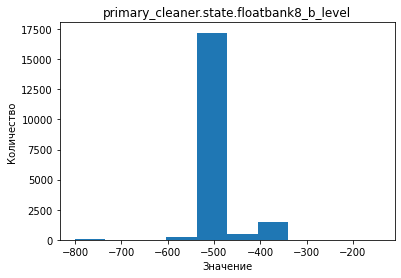

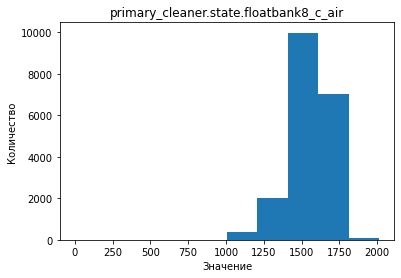

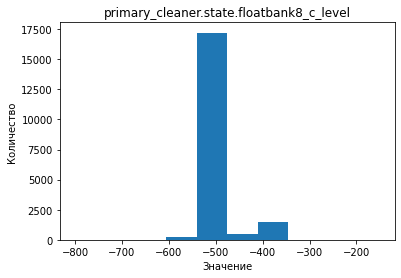

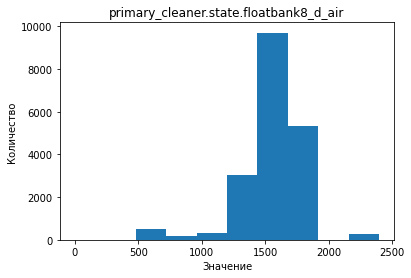

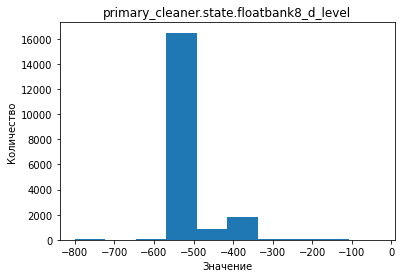

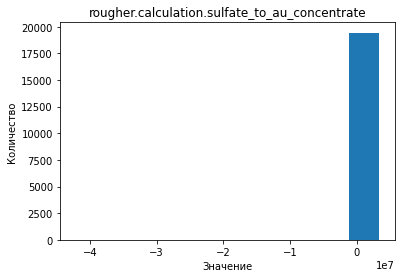

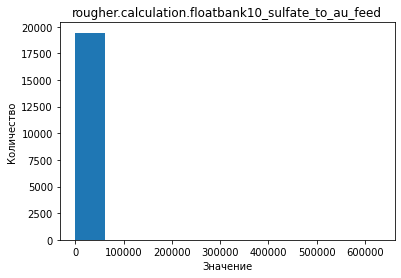

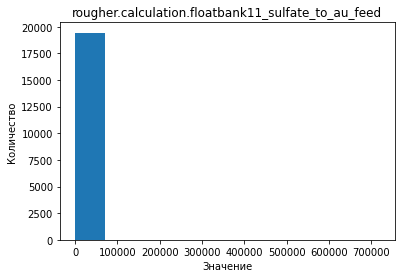

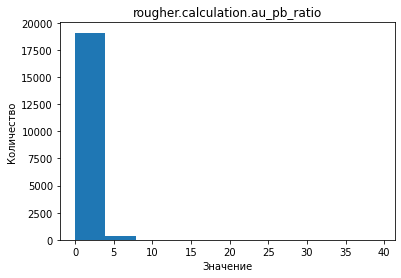

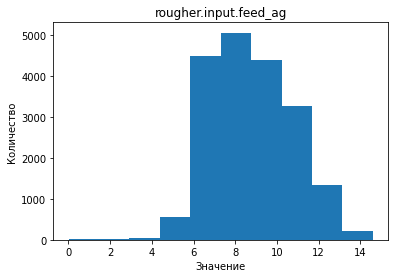

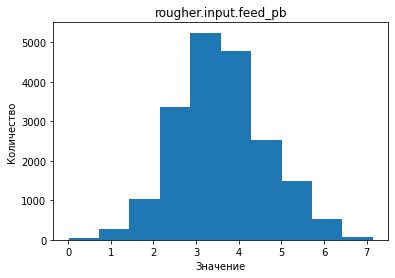

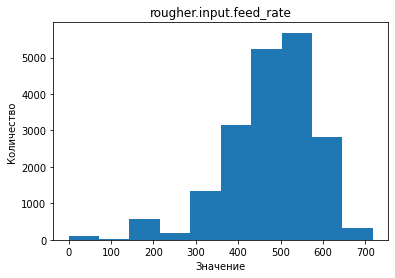

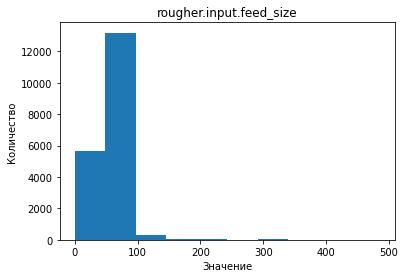

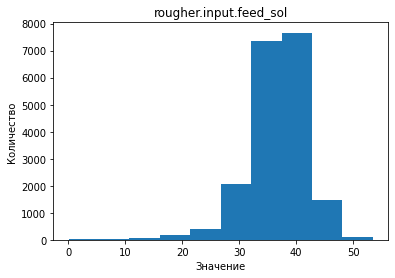

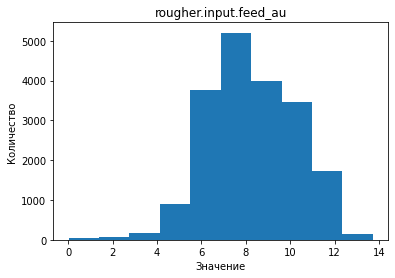

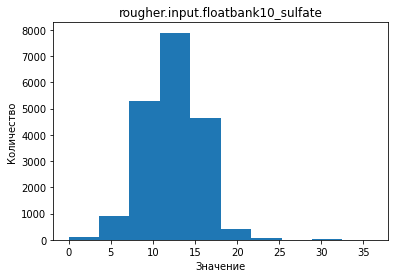

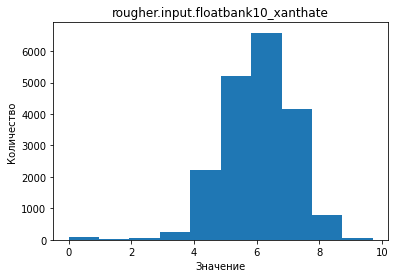

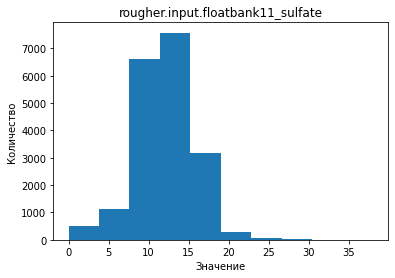

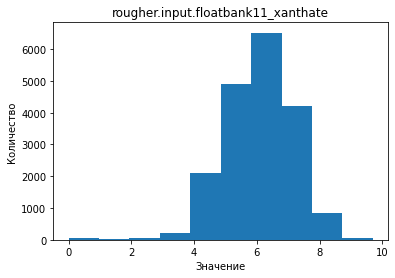

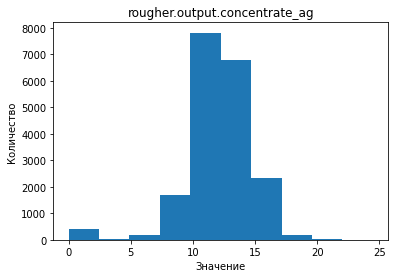

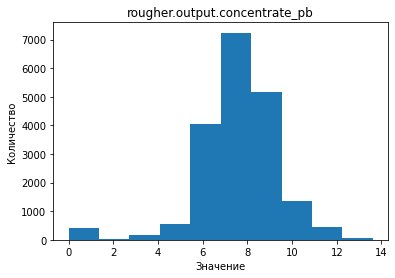

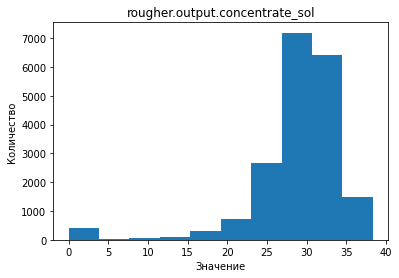

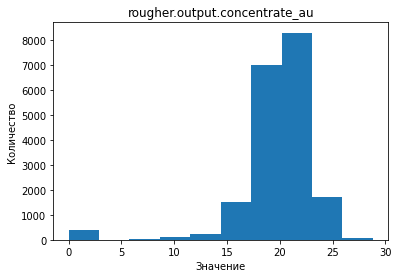

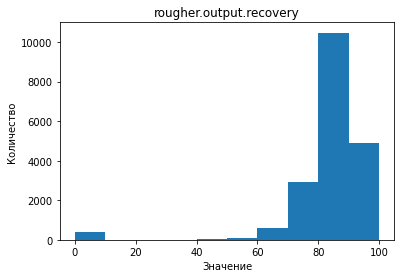

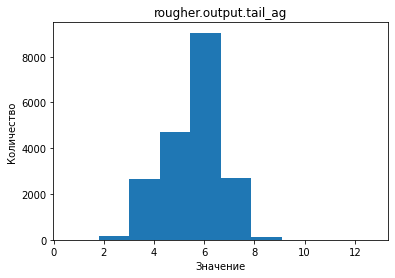

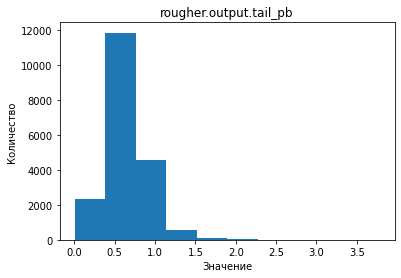

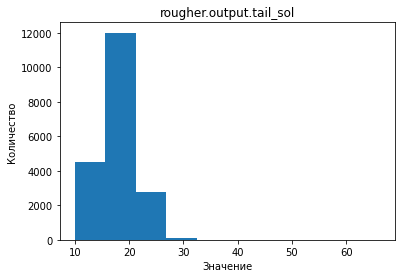

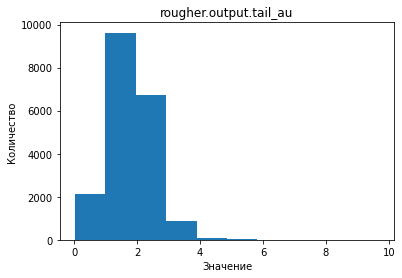

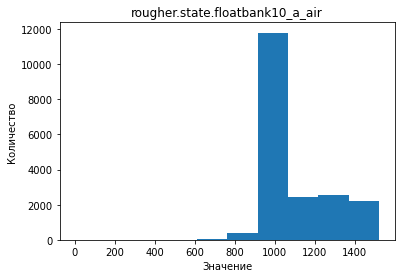

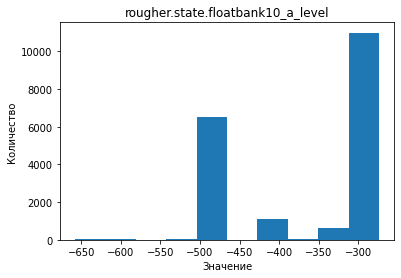

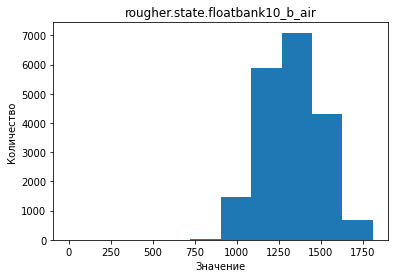

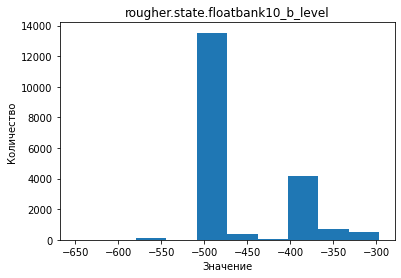

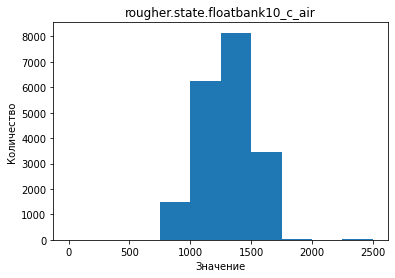

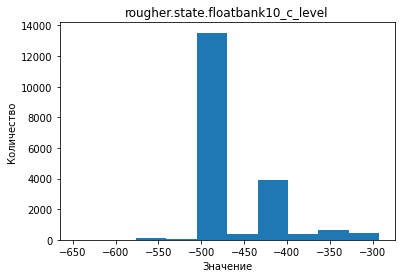

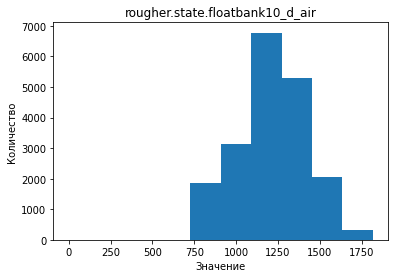

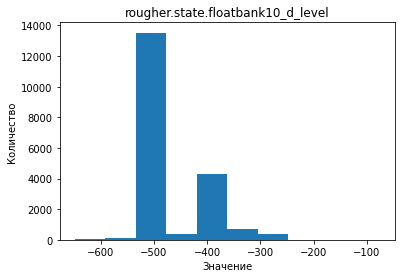

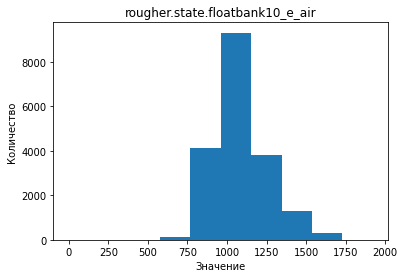

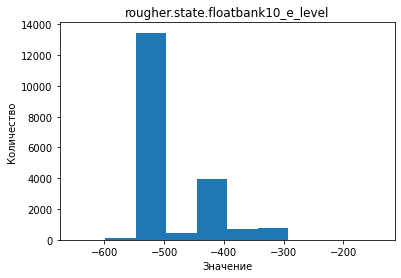

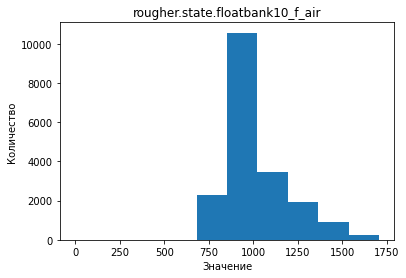

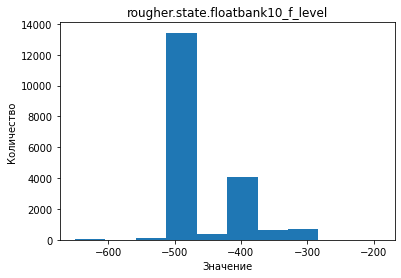

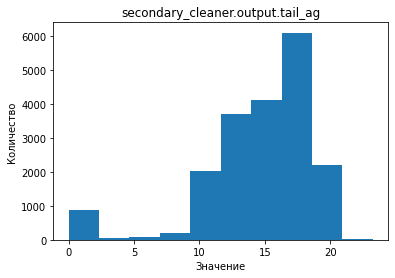

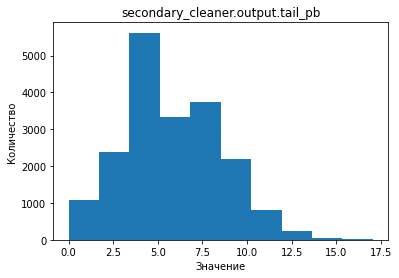

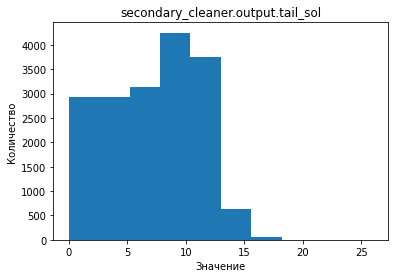

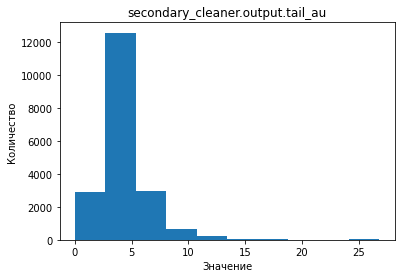

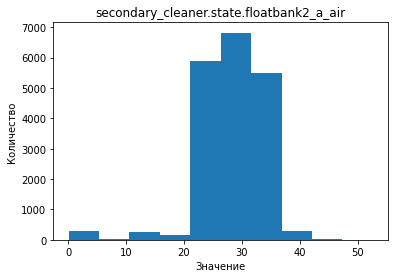

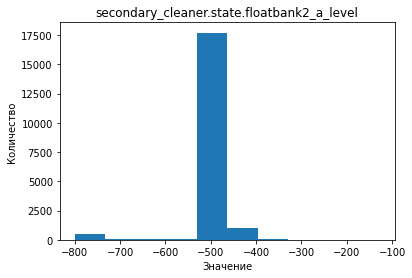

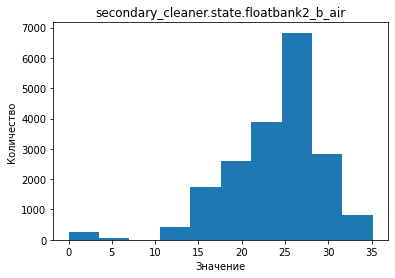

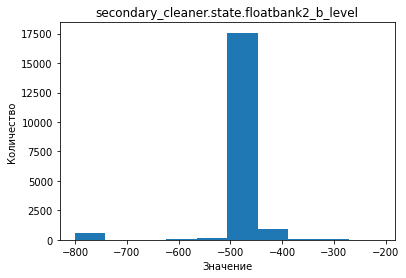

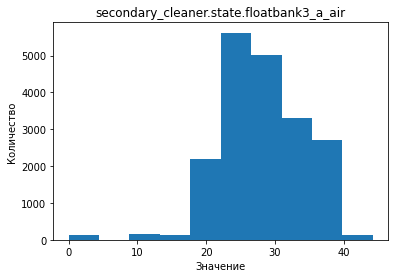

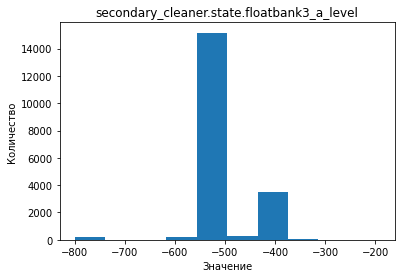

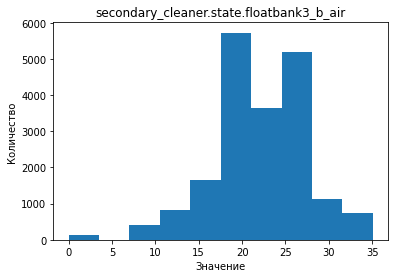

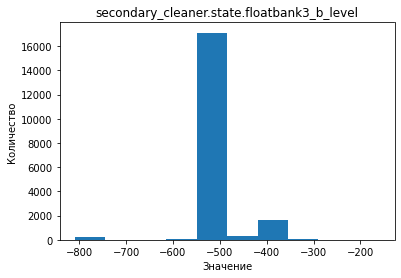

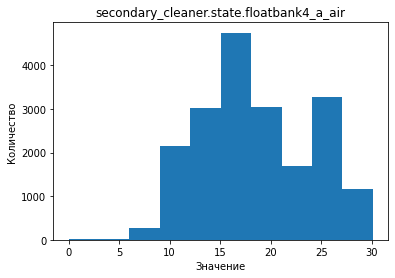

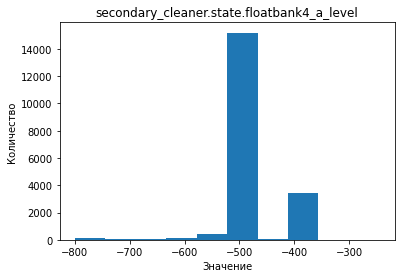

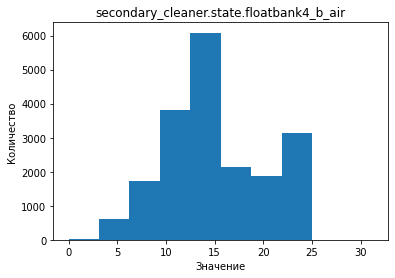

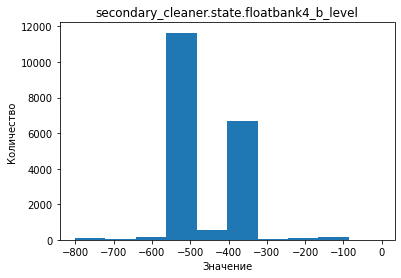

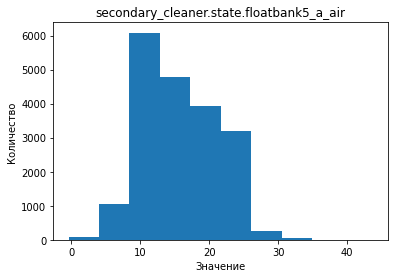

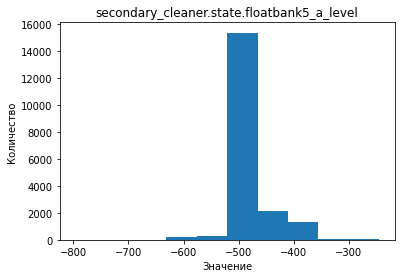

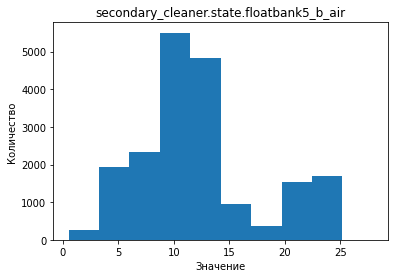

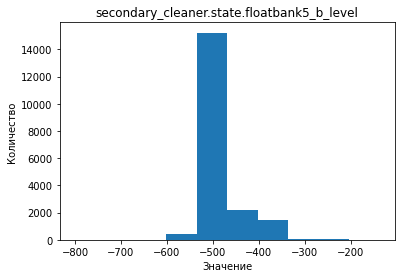

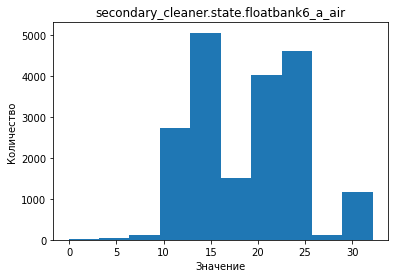

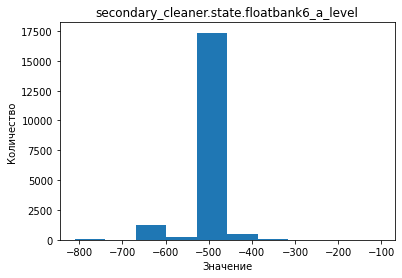

In [7]:
# посмотрим распределение данных
for column in data_full.columns[1:]:
    data = data_full[[column]]
    plt.hist(data)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show()

### Проверим, что эффективность обогащения рассчитана правильно

In [8]:
# вычислим эффективность обогащения на обучающей выборке
CONCENTRATE = data_train['rougher.output.concentrate_au']
FEED = data_train['rougher.input.feed_au']
TAIL = data_train['rougher.output.tail_au']

In [9]:
# создадим новый столбец для наших вычислений
data_train['recovery_calc'] = ((CONCENTRATE*(FEED-TAIL))/(FEED*(CONCENTRATE-TAIL)))*100
data_train['recovery_calc'].mean()

82.70450164550293

In [10]:
# сравним с прзнаком rougher.output.recovery
data_train['rougher.output.recovery'].mean()

82.70450164550293

Значения совпадают, поэтому эффективность похоже рассчитана правильно.

In [11]:
# Найдем среднюю абсолютную ошибку (MAE) между нашими расчётами и значением признака
print(mean_absolute_error(data_train['recovery_calc'], data_train['rougher.output.recovery']))

9.73512347450521e-15


In [12]:
# удаляем наш столбец
data_train.drop('recovery_calc', axis=1, inplace=True)

Значение MAE очень маленькое, значит это еще раз подтверждает вывод, что эффективность обогащения рассчитана правильно.

### Проанализируем признаки, недоступные в тестовой выборке.

In [13]:
# найдем признаки недоступные в тестовой выборке
set(data_train.columns)-set(data_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Эти признаки отсутствуют в тестовой выборке. Мы видим, что это признаки, которые относятся к вторичным стадиям обогащения, параметры продуктов(а не сырья), расчетные характеристики, относящиеся к разным этапам, т.е значения final.output, primary_cleaner.output, rougher.calculations, rougher.output, secondary_cleaner.output

### Проведем предобработку данных

In [14]:
# добавим недостающие данные в data_test
data_test = data_test.merge(data_full[['final.output.recovery', 'rougher.output.recovery', 'date']], how='left', on='date')

In [15]:
# Смотрим количество пропусков
pd.DataFrame(data_full.isna().sum(), columns = ['пропуски']).style.background_gradient('coolwarm')

,пропуски
date,0
final.output.concentrate_ag,1
final.output.concentrate_pb,1
final.output.concentrate_sol,211
final.output.concentrate_au,0
final.output.recovery,0
final.output.tail_ag,1
final.output.tail_pb,101
final.output.tail_sol,6
final.output.tail_au,0


In [16]:
# Заполним пропуски ближайшими значениями
data_train = data_train.fillna(method='bfill')
data_test = data_test.fillna(method='bfill')
data_full = data_full.fillna(method='bfill')

In [17]:
# проверим количесто оставшихся пропусков
print('Количество строк с пропусками в data_train', data_train.isna().sum().sum())
print('Количество строк с пропусками в data_test', data_test.isna().sum().sum())
print('Количество строк с пропусками в data_full', data_full.isna().sum().sum())

Количество строк с пропусками в data_train 0
Количество строк с пропусками в data_test 0
Количество строк с пропусками в data_full 0


### Вывод

В данном разделе открыты файлы и изучены основные данные.

Построены графика распределения значений по всем числовым полям. Большинство признаков имеют нормальное распределение, но вместе с тем встречаются и скошенные распределения. Также у некоторых признаков видно значимое число значений в области нуля. Вероятно это выбросы. В дальнейшем анализе нужно обратить на них внимание.

Проверен расчёт эффективности обогащения. Вычислено значение MAE между данными и расчётными значениями эффективности. Полученные значения МАЕ близки к 0. Это означаем, что эффективность обогащения рассчитана правильно. ПРоанализированы поля недоступные в тестовой выборке, где отсутствуют целевые признаки для моделей 'rougher.output.recovery', 'final.output.recovery', а также значения output по всем операциям по всем элементам. Это концентрации элементов после основных операций. Это фактические даные, которые мы можем получить только по факту реальных измерений. А задача ML-модели получение прогноза. Поэтому в реальности у нас и не должно быть этих данных в файле test.

Проведена проверка на дубликаты. Обработаны пропуски.

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [18]:
#отфильтруем даные для серебра
data_ag = data_full[['rougher.output.concentrate_ag', 
              'primary_cleaner.output.concentrate_ag', 
              'final.output.concentrate_ag']]
#переименуем столбцы для лучшей читаемости
data_ag = data_ag.rename(columns={'rougher.output.concentrate_ag': 'флотация', 
                              'primary_cleaner.output.concentrate_ag': 'первичная очистка', 
                              'final.output.concentrate_ag': 'финальная очистка'})

In [19]:
#отфильтруем даные для свинца
data_pb = data_full[['rougher.output.concentrate_pb', 
              'primary_cleaner.output.concentrate_pb', 
              'final.output.concentrate_pb']]
#переименуем столбцы для лучшей читаемости
data_pb = data_pb.rename(columns={'rougher.output.concentrate_pb': 'флотация', 
                              'primary_cleaner.output.concentrate_pb': 'первичная очистка', 
                              'final.output.concentrate_pb': 'финальная очистка'})


In [20]:
#отфильтруем даные для золота
data_au = data_full[['rougher.output.concentrate_au', 
              'primary_cleaner.output.concentrate_au', 
              'final.output.concentrate_au']]
#переименуем столбцы для лучшей читаемости
data_au = data_au.rename(columns={'rougher.output.concentrate_au': 'флотация', 
                              'primary_cleaner.output.concentrate_au': 'первичная очистка', 
                              'final.output.concentrate_au': 'финальная очистка'})

Text(0.5, 0.98, 'Изменение концентрации металлов на различных этапах очистки')

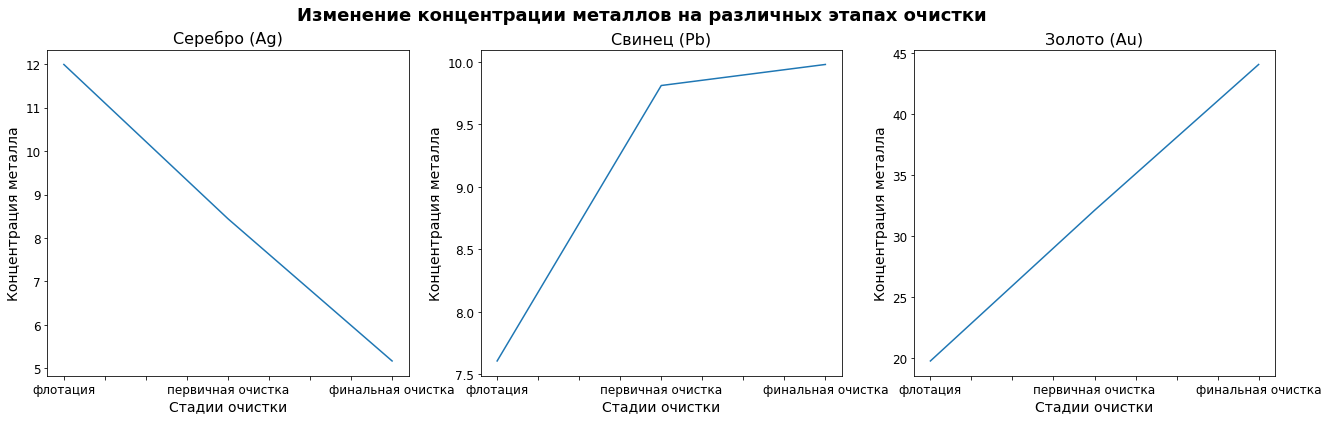

In [21]:
#построим графики для каждого металла.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, linewidth=3, figsize=(22, 6))#1 ряд, 3 графика

data_ag.mean().plot(ax=ax1, subplots=True, fontsize=12)
ax1.set_title('Серебро (Ag)', fontsize=16)
ax1.set_ylabel('Концентрация металла', fontsize=14)
ax1.set_xlabel('Стадии очистки', fontsize=14)

data_pb.mean().plot(ax=ax2, subplots=True, fontsize=12)
ax2.set_title('Свинец (Pb)', fontsize=16)
ax2.set_ylabel('Концентрация металла', fontsize=14)
ax2.set_xlabel('Стадии очистки', fontsize=14)

data_au.mean().plot(ax=ax3, subplots=True, fontsize=12)
ax3.set_title('Золото (Au)', fontsize=16)
ax3.set_ylabel('Концентрация металла', fontsize=14)
ax3.set_xlabel('Стадии очистки', fontsize=14)


plt.suptitle('Изменение концентрации металлов на различных этапах очистки', fontsize=18, fontweight='bold')


* Концентрация серебра уменьшается в процессе очистки. Самая большая концентрация на первой стадии и самая маленькая на конечной.

* Концентрация свинца значительно повышается от стадии флотации к первичной очистке, и еще немного повышается на стадии финальной очистки.

* Концентрация золота равномерно повышается от флотации до финальной очистки.

### Распределения размеров гранул сырья

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.



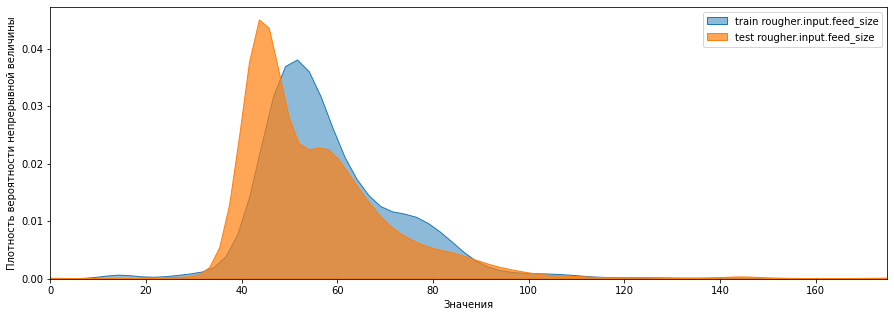

count    14149.000000
mean        59.955950
std         23.286534
min          9.659576
25%         48.920770
50%         55.301596
75%         65.941463
max        484.967466
Name: rougher.input.feed_size, dtype: float64
count    5290.000000
mean       55.952917
std        19.080412
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64


In [22]:
# Визуализация концентрации размера сырья на входе флотации train и test
plt.figure(figsize=(15, 5))
sns.kdeplot(data_train['rougher.input.feed_size'], label='train rougher.input.feed_size', alpha=0.5, shade=True)
sns.kdeplot(data_test['rougher.input.feed_size'], label='test rougher.input.feed_size', alpha=0.7, shade=True)
plt.xlim([0, 175])
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности непрерывной величины')
plt.legend(loc='upper right')
plt.show()
print(data_train['rougher.input.feed_size'].describe())
print(data_test['rougher.input.feed_size'].describe())

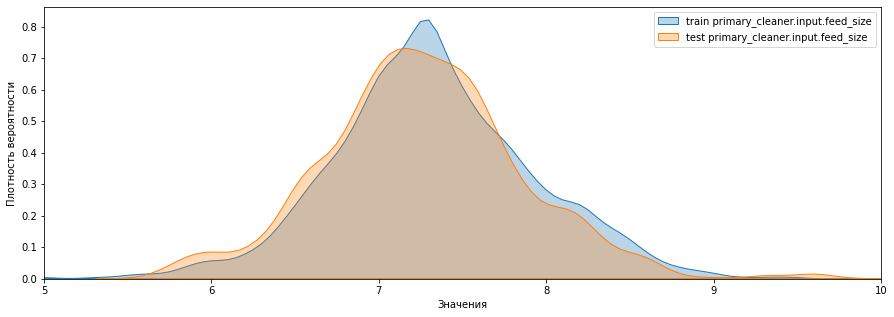

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64
count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


In [23]:
# Визуализация концентрации размера сырья на входе финальной очистки train и test
plt.figure(figsize=(15, 5))
sns.kdeplot(data_train['primary_cleaner.input.feed_size'], 
         label='train primary_cleaner.input.feed_size', alpha=0.3, shade=True)
sns.kdeplot(data_test['primary_cleaner.input.feed_size'],  
         label='test primary_cleaner.input.feed_size', alpha=0.3, shade=True)
plt.xlim([5, 10])
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend(loc='upper right')
plt.show()
print(data_train['primary_cleaner.input.feed_size'].describe())
print(data_test['primary_cleaner.input.feed_size'].describe())


- Построены графики распределения плотности вероятности значений размеров гранул на входе в этапы флотации и финальной очистки выборок train и test

-  распределения похожи, что говорит об однородности данных размеров сырья в выборках train и test

### Суммарная концентрация всех веществ на разных стадиях

In [24]:
sum_concentrate_of_rougher_input = 0
sum_concentrate_of_rougher_output = 0
sum_concentrate_of_primary_cleaner_output = 0
sum_concentrate_of_final_output = 0
for metal in ['au', 'ag', 'pb', 'sol']:
    sum_concentrate_of_rougher_input += data_train[f'rougher.input.feed_{metal}']
    sum_concentrate_of_rougher_output += data_train[f'rougher.output.concentrate_{metal}']
    sum_concentrate_of_primary_cleaner_output += data_full[f'primary_cleaner.output.concentrate_{metal}']
    sum_concentrate_of_final_output += data_train[f'final.output.concentrate_{metal}']

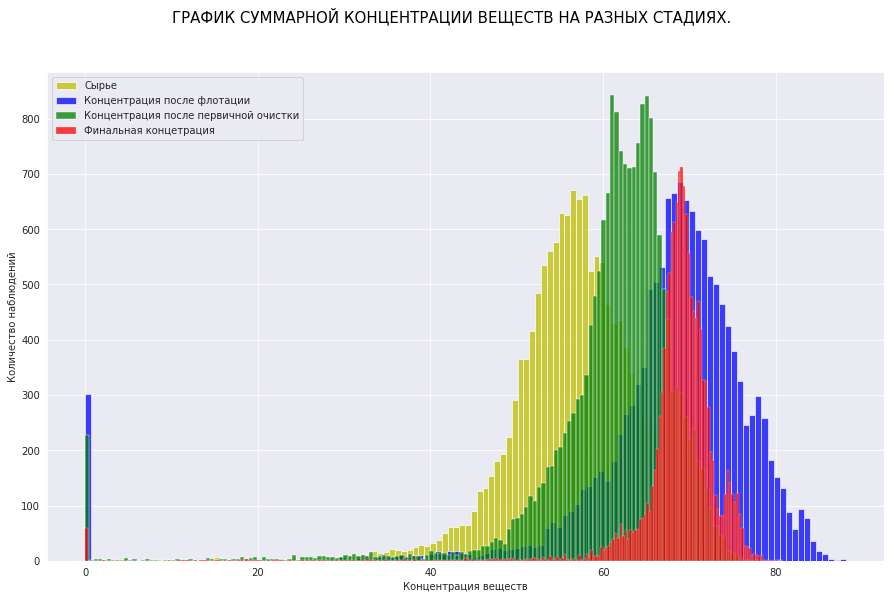

In [25]:
plt.figure(figsize=[15, 9])
plt.suptitle('ГРАФИК СУММАРНОЙ КОНЦЕНТРАЦИИ ВЕЩЕСТВ НА РАЗНЫХ СТАДИЯХ.', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(sum_concentrate_of_rougher_input, color='y', label='Сырье', kde=False)
sns.histplot(sum_concentrate_of_rougher_output, color='b', label='Концентрация после флотации', kde=False)
sns.histplot(sum_concentrate_of_primary_cleaner_output, color='g', label='Концентрация после первичной очистки', kde=False)
sns.histplot(sum_concentrate_of_final_output, color='r', label='Финальная концетрация',kde=False)
plt.xlabel('Концентрация веществ')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

Суммарная концентрация веществ увеличивается к финальному этапу, а диапазон распределения суммарной концентрации веществ уменьшается.

Для финального и этапа флотации для суммарной концентрации веществ присутствуют аномалии ( значения в районе 0). Считаю необходимым удалить аномалии из данных. Аномалии могут негативно повлиять на качество обучения модели

In [26]:
data_train = data_train[(data_train['rougher.output.concentrate_au'] != 0) & (data_train['rougher.output.concentrate_ag'] != 0) & (data_train['rougher.output.concentrate_pb'] != 0) & (data_train['rougher.output.concentrate_sol'] != 0)]
data_train = data_train[(data_train['final.output.concentrate_au'] != 0) & (data_train['final.output.concentrate_ag'] != 0) & (data_train['final.output.concentrate_pb'] != 0) & (data_train['final.output.concentrate_sol'] != 0)]

data_full = data_full[(data_full['rougher.output.concentrate_au'] != 0) & (data_full['rougher.output.concentrate_ag'] != 0) & (data_full['rougher.output.concentrate_pb'] != 0) & (data_full['rougher.output.concentrate_sol'] != 0)]
data_full = data_full[(data_full['final.output.concentrate_au'] != 0) & (data_full['final.output.concentrate_ag'] != 0) & (data_full['final.output.concentrate_pb'] != 0) & (data_full['final.output.concentrate_sol'] != 0)]

###### Подготовим датафреймы для прогнозирования features, target


Оставляем в features_train только признаки из data_test за исключением целевых



In [27]:
# список признаков для обучения модели
features_columns = list(data_test.columns)[1:-2]

In [28]:
# список целевых признаков
target_columns = list(reversed(list(data_test.columns)[-2:]))

In [29]:
target_columns

['rougher.output.recovery', 'final.output.recovery']

In [30]:
# формируем необходимые для обучения и оценки датафреймы
features_train = data_train[features_columns]
target_train = data_train[target_columns]
features_test = data_test[features_columns]
target_test = data_test[target_columns]

### Вывод

Анализ концентрации металлов показал, что концентрация золота значительно увеличивается на каждом этапе обработки сырья. Концентрация золота в отвалах тоже увеличивается, но при этом на порядок ниже чем в сырье. На всех графиках концентрации сырья видны значения равные нулю. Судя по распределению, это выбросы.

Построены графики распределения плотности вероятности значений размеров гранул на входе в этапы флотации и финальной очистки выборок train и test Сами распределения похожи, что говорит об однородности данных размеров сырья в выборках train и test

Суммарная концентрация веществ увеличивается к финальному этапу, а диапазон распределения суммарной концентрации веществ уменьшается.

Подготовлены датафреймы для прогнозирования features, target



## Модель

### Функция для вычисления итоговой sMAPE


In [31]:
def smape_func(target, pred):
    '''Метод получения sMape для одного этапа'''
    
    smape = abs(target-pred)/((abs(target)+abs(pred))/2)*100
    smape = smape.fillna(value=0)

    smape = np.mean(smape)
    return smape

In [32]:
def summary_smape_func(target_rouger, pred_rougher, target_final, pred_final):
    
    '''Метод для вычисления итоговой sMAPE, когда на входе target_rouger, pred_rougher, target_final, pred_final'''
    
    # вычислим smape для rouger
    smape_rouger = smape_func(target_rouger, pred_rougher)
    # вычислим smape для final
    smape_final = smape_func(target_final, pred_final)
    
    #  вычислим итоговый smape
    summary_smape = 0.25 * smape_rouger + 0.75 * smape_final
    
    return summary_smape

In [33]:
def summary_smape(smape_rouger, smape_final):
    
    '''Метод для вычисления итоговой sMAPE, когда на входе smape_rouger и smape_final'''
    
    #  вычислим итоговый smape
    summary_smape = 0.25 * smape_rouger + 0.75 * smape_final
    
    return summary_smape

Обучим разные модели и оценим их качество кросс-валидацией: 

* Линейная регрессия

* Дерево решений

* Случайный лес

Выберем лучшую модель и проверим её на тестовой выборке.

### Линейная регрессия


In [34]:
smape_scorer = make_scorer(smape_func, greater_is_better=False)

In [35]:
# инициируем модель линейной регрессии
model_lr_rougher = LinearRegression()

In [36]:
# оценим модель с помощью кроссвалидации features_train, target_train. Вычислим sMape_rougher
scores_lr_rougher = cross_val_score(model_lr_rougher,  
                                          features_train, 
                                          target_train['rougher.output.recovery'], 
                                          scoring = smape_scorer,
                                          cv = 5)
smape_rougher = np.mean(abs(scores_lr_rougher))
print('Средняя оценка качества sMape_rougher', round(smape_rougher, 4))


Средняя оценка качества sMape_rougher 7.1889


In [37]:
# оценим модель с помощью кроссвалидации features_train, target_train. Вычислим score_final
scores_lr_rougher = cross_val_score(model_lr_rougher,  
                                          features_train, 
                                          target_train['final.output.recovery'], 
                                          scoring = smape_scorer,
                                          cv = 5)
smape_final = np.mean(abs(scores_lr_rougher))
print('Средняя оценка качества sMape_final', round(smape_final, 4))

Средняя оценка качества sMape_final 10.9916


In [38]:
# вычислим итоговую оценку sMape
smape_total = summary_smape(smape_rougher, smape_final)
print('Средняя итоговая оценка качества модели sMape ', round(smape_total, 4))

Средняя итоговая оценка качества модели sMape  10.041


### Дерево решений


In [39]:
# Проведем оценку модели дерева решений с заданным параметром глубины 10

# Проведем оценку для этапа rougher

# Инициируем модель дерева решений
model_dt_rougher = DecisionTreeRegressor(random_state=12345, max_depth = 10)


# оценим модель с помощью кроссвалидации features_train, target_train. Вычислим sMape_rougher
scores_dt_rougher = cross_val_score(model_dt_rougher,  
                                          features_train, 
                                          target_train['rougher.output.recovery'], 
                                          scoring = smape_scorer,
                                          cv = 5)
smape_rougher = np.mean(abs(scores_dt_rougher))
print('Средняя оценка качества smape_rougher', round(smape_rougher, 4))

Средняя оценка качества smape_rougher 9.0023


In [40]:
# Проведем оценку для этапа final

# Инициируем модель дерева решений
model_dt_final = DecisionTreeRegressor(random_state=12345, max_depth = 10)


# оценим модель с помощью кроссвалидации features_train, target_train. Вычислим sMape_rougher
scores_dt_final = cross_val_score(model_dt_final,  
                                          features_train, 
                                          target_train['final.output.recovery'], 
                                          scoring = smape_scorer,
                                          cv = 5)
smape_final = np.mean(abs(scores_dt_final))
print('Средняя оценка качества smape_final', round(smape_final, 4))

Средняя оценка качества smape_final 14.3047


In [41]:
# вычислим итоговую оценку sMape
smape_total = summary_smape(smape_rougher, smape_final)
print('Средняя итоговая оценка качества модели sMape', round(smape_total, 4))

Средняя итоговая оценка качества модели sMape 12.9791


Проведем оценку модели дерева решений но уже с подбором параметра глубины


In [42]:
%%time
# Проведем оценку модели дерева решений но уже с подбором параметра глубины для этапа rougher
# Инициируем модель дерева решений
model_dt_rougher = DecisionTreeRegressor(random_state=12345)
# подберем оптимальные параметры глубины дерева
parameters = {'max_depth': [x for x in range(1, 30, 2)]}

grid_dt_rougher = GridSearchCV(model_dt_rougher,
                               parameters, 
                               cv=5, 
                               scoring=smape_scorer)
grid_dt_rougher.fit(features_train, target_train['rougher.output.recovery'])

CPU times: user 43.4 s, sys: 134 ms, total: 43.5 s
Wall time: 43.9 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                       23, 25, 27, 29]},
             scoring=make_scorer(smape_func, greater_is_better=False))

In [43]:
# Смотрим лучшие параметры по глубине. Значение smape берем по модулю
print(grid_dt_rougher.best_params_)
print('Значение smape_rougher берем по модулю', abs(round(grid_dt_rougher.best_score_, 3)))

{'max_depth': 3}
Значение smape_rougher берем по модулю 7.05


In [44]:
%%time
# Проведем оценку модели дерева решений но уже с подбором параметра глубины для этапа final
# Инициируем модель дерева решений
model_dt_final = DecisionTreeRegressor(random_state=12345)
# подберем оптимальные параметры глубины дерева
parameters = {'max_depth': [x for x in range(1, 30, 2)]}

grid_dt_final = GridSearchCV(model_dt_final,
                               parameters, 
                               cv=5, 
                               scoring=smape_scorer)
grid_dt_final.fit(features_train, target_train['final.output.recovery'])

# Смотрим лучшие параметры по глубине. Значение smape берем по модулю
print(grid_dt_final.best_params_)
print('Значение smape_final берем по модулю', abs(round(grid_dt_final.best_score_, 3)))


{'max_depth': 3}
Значение smape_final берем по модулю 9.46
CPU times: user 47.2 s, sys: 152 ms, total: 47.4 s
Wall time: 47.5 s


In [45]:
# вычислим итоговую оценку dtree_smape_total
dt_smape_total = summary_smape(abs(round(grid_dt_rougher.best_score_, 3)), abs(round(grid_dt_final.best_score_, 3)))
print('Средняя итоговая оценка качества модели dtree_smape_total', round(smape_total, 4))


Средняя итоговая оценка качества модели dtree_smape_total 12.9791


### Случайный лес


In [46]:
%%time
# Проведем оценку модели случайного леса с заданными параметрами для этапа rougher
#  инициируем модель случайного леса
model_rf_rougher = RandomForestRegressor(random_state=12345, max_depth = 10, n_estimators=20)

# оценим модель с помощью кроссвалидации features_train, target_train
scores_rf_rougher = cross_val_score(model_rf_rougher,
                                    features_train, 
                                    target_train['rougher.output.recovery'],
                                    scoring=smape_scorer,
                                    cv = 5)
smape_rf_rougher = np.mean(abs(scores_rf_rougher))
print('Средняя оценка качества модели final_score_rf_rougher', round(smape_rf_rougher, 4))

Средняя оценка качества модели final_score_rf_rougher 7.293
CPU times: user 29.3 s, sys: 143 ms, total: 29.4 s
Wall time: 29.4 s


In [47]:
%%time
# Проведем оценку модели случайного леса с заданными параметрами для этапа final
#  инициируем модель случайного леса
model_rf_final = RandomForestRegressor(random_state=12345, max_depth = 10, n_estimators=20)

# оценим модель с помощью кроссвалидации features_train, target_train
scores_rf_final = cross_val_score(model_rf_final,
                                    features_train, 
                                    target_train['final.output.recovery'],
                                    scoring=smape_scorer,
                                    cv = 5)
smape_rf_final = np.mean(abs(scores_rf_final))
print('Средняя оценка качества модели final_score_rf_rougher', round(smape_rf_final, 4))

Средняя оценка качества модели final_score_rf_rougher 9.8265
CPU times: user 30.5 s, sys: 84.6 ms, total: 30.6 s
Wall time: 30.9 s


In [48]:
# вычислим итоговую оценку smape_rf_total 
smape_rf_total = summary_smape(smape_rf_rougher, smape_rf_final)
print('Средняя итоговая оценка качества модели smape_rf_total', round(smape_rf_total, 4))

Средняя итоговая оценка качества модели smape_rf_total 9.1931


In [49]:
%%time
# Проведем оценку модели случайного леса с подбором параметров для этапа rougher

#  инициируем модель случайного леса
model_rf_rougher = RandomForestRegressor(random_state=12345)

# подберем оптимальные параметры глубины дерева
parameters = { 'max_depth': [x for x in range(2, 12, 3)],
               'n_estimators': [x for x in range(100, 250, 50)]
             }

grid_rf_rougher = GridSearchCV(model_rf_rougher, 
                               parameters, 
                               cv=5, 
                               scoring=smape_scorer
                              )
grid_rf_rougher.fit(features_train, target_train['rougher.output.recovery'])


CPU times: user 30min 31s, sys: 4.31 s, total: 30min 35s
Wall time: 30min 37s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [2, 5, 8, 11],
                         'n_estimators': [100, 150, 200]},
             scoring=make_scorer(smape_func, greater_is_better=False))

In [50]:
print('Лучшие параметры: ', grid_rf_rougher.best_params_)
print('smape_rougher', abs(round(grid_rf_rougher.best_score_, 3)))

Лучшие параметры:  {'max_depth': 5, 'n_estimators': 100}
smape_rougher 6.628


In [51]:
%%time
# Проведем оценку модели случайного леса с подбором параметров для этапа final
#  инициируем модель случайного леса
model_rf_final = RandomForestRegressor(random_state=12345)

# подберем оптимальные параметры глубины дерева
parameters = { 'max_depth': [x for x in range(2, 12, 3)],
               'n_estimators': [x for x in range(100, 250, 50)]
             }

grid_rf_final = GridSearchCV(model_rf_final, 
                               parameters, 
                               cv=5, 
                               scoring=smape_scorer
                              )
grid_rf_final.fit(features_train, target_train['final.output.recovery'])

CPU times: user 30min 41s, sys: 3.93 s, total: 30min 45s
Wall time: 30min 47s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [2, 5, 8, 11],
                         'n_estimators': [100, 150, 200]},
             scoring=make_scorer(smape_func, greater_is_better=False))

In [52]:
print('Лучшие параметры: ', grid_rf_final.best_params_)
print('smape_rougher', round(abs(grid_rf_final.best_score_), 3))

Лучшие параметры:  {'max_depth': 2, 'n_estimators': 150}
smape_rougher 9.269


In [53]:
# вычислим итоговую оценку smape_rf_total с учётом подбора параметров 
smape_rf_total = summary_smape(abs(round(grid_rf_rougher.best_score_, 3)), abs(round(grid_rf_final.best_score_, 3)))
print('Средняя итоговая оценка качества модели smape_rf_total', round(smape_rf_total, 4))

Средняя итоговая оценка качества модели smape_rf_total 8.6088


На данный момент для дальнешего прогнозирования выбираем **случайного леса** с параметрами:

* для этапа rougher глубина 5, количество деревьев 100.
* этапа final глубина 2, количество деревьев 150.

Эти параметры позволяют получить на кросс-валидации показатель smape равный 7.8902

### Расчёт по выбранной модели


In [54]:
def rf_model(features_train, target_train, features_test, depth, estimators):
    # метод прогнозирования целевого признаки на случайном лесе

    # инициируем модель с лучшими параметрами
    model_rf = RandomForestRegressor(random_state=12345, max_depth = depth, n_estimators=estimators)
    # обучим модель
    model_rf.fit(features_train, target_train)
    # подготовим прогноз целевого признака
    prediction_test_rf = model_rf.predict(features_test)

    return prediction_test_rf

In [55]:
# спрогнозируем эффективность для этапа rougher
prediction_test_rougher = rf_model(features_train, target_train['rougher.output.recovery'], features_test, 5, 150)

In [56]:
# спрогнозируем эффективность для этапа final
prediction_test_final = rf_model(features_train, target_train['final.output.recovery'], features_test, 5, 200)

In [57]:
# рассчитаем smape на тестовых данных
smape_test = summary_smape_func(target_test['rougher.output.recovery'], 
                                prediction_test_rougher,
                                target_test['final.output.recovery'],
                                prediction_test_final                               
                               )


In [58]:
print('Итоговая оценка smape на тестовых данных равна', round(smape_test, 2))

Итоговая оценка smape на тестовых данных равна 9.37


### Проверка модели на адекватность


In [59]:
def const_model(features_train, target_train, features_test):
    # метод прогнозирования целевого признаки на константной модели 

    # инициируем модель с лучшими параметрами
    dummy_reg = DummyRegressor(strategy="mean")
    # обучим модель
    dummy_reg.fit(features_train, target_train)
    # подготовим прогноз целевого признака
    prediction_test = dummy_reg.predict(features_test)
    return prediction_test

In [60]:
# построим прогноз константной модели для этапа rougher
prediction_test_rougher_const = const_model(features_train, target_train['rougher.output.recovery'], features_test)

In [61]:
# построим прогноз константной модели для этапа final
prediction_test_final_const = const_model(features_train, target_train['final.output.recovery'], features_test)

In [62]:
# рассчитаем smape на тестовых данных
smape_test_const = summary_smape_func(target_test['rougher.output.recovery'], 
                                prediction_test_rougher_const,
                                target_test['final.output.recovery'],
                                prediction_test_final_const                               
                               )

In [63]:
print('Итоговая оценка smape константной модели на тестовых данных равна', round(smape_test_const, 3))

Итоговая оценка smape константной модели на тестовых данных равна 9.823


## Выводы


В рамках предобработки данных проекта, изучены загруженные файлы:

* Построены графика распределения значений по всем числовым полям. Большинство признаков имеют нормальное распределение, но вместе с тем встречаются и скошенные распределения. Также у некоторых признаков видно значимое число значений в области нуля. В дальнейшем эти выбросы были удалены.

* Проверен расчёт эффективности обогащения. Вычислено значение MAE между данными и расчётными значениями эффективности. Значение MAE очень маленькое, значит это еще раз подтверждает вывод, что эффективность обогащения рассчитана правильно.

* Проанализированы поля недоступные в тестовой выборке, где отсутствуют целевые признаки для моделей 'rougher.output.recovery', 'final.output.recovery', а также значения output по всем операциям по всем элементам. 

* Проведена проверка на дубликаты. Обработаны пропуски. Исключительно для проверки качества оценки моедли поля 'rougher.output.recovery', 'final.output.recovery' добавлены в тестовый файл для формирования выборки target_test.

* Концентрация серебра уменьшается в процессе очистки. Самая большая концентрация на первой стадии и самая маленькая на конечной.Концентрация свинца значительно повышается от стадии флотации к первичной очистке, и еще немного повышается на стадии финальной очистки.Концентрация золота равномерно повышается от флотации до финальной очистки.

* Построены графики распределения плотности вероятности значений размеров гранул на входе в этапы флотации и финальной очистки выборок train и test Сами распределения похожи, что говорит об однородности данных размеров сырья в выборках train и test

* Суммарная концентрация веществ увеличивается к финальному этапу, а диапазон распределения суммарной концентрации веществ уменьшается.

* Подготовлены датафреймы для прогнозирования features, target

* На данных train обучены модели линейной регрессии, дерева решений, а также случайного леса. Проведена оценка каждой модели. В результате для дальнешего прогнозирования выбирана модель случайного леса с параметрами

1. для этапа rougher глубина 5, количество деревьев 100.
2. для этапа final глубина 2, количество деревьев 150.

* Эти параметры позволяют получить на данных train показатель smape равный 7.8902

* Итоговый расчёт на тестовых данных выбранной модели случайного леса позволил получить прогноз целевых признаков концентрации золота для этапа флотации и финальной очистки с показателем smape равным 9.37

* Проведена проверка модели на адекватность. Итоговая оценка smape константной модели на тестовых данных равна 9.823